<a href="https://colab.research.google.com/github/AdaobiAjayi/MalaraiaProject/blob/main/Ada's_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Malaria Prediction Using SARIMA and LSTM Models

In this project, we aim to predict malaria cases over time using two different models: SARIMA (Seasonal Autoregressive Integrated Moving Average) and LSTM (Long Short-Term Memory) neural networks. Malaria is a major public health concern in many regions, and accurate prediction models can help in resource allocation and preparedness.

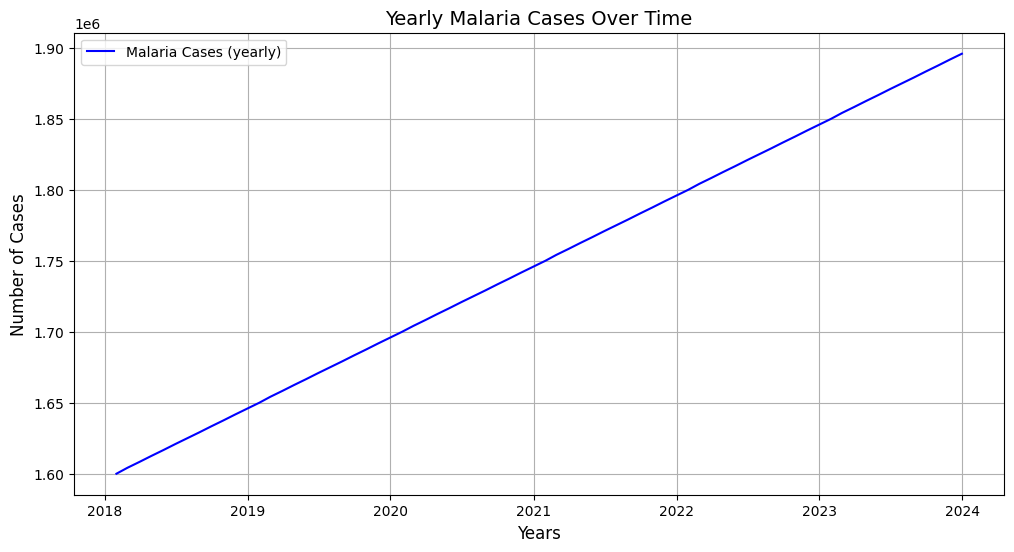

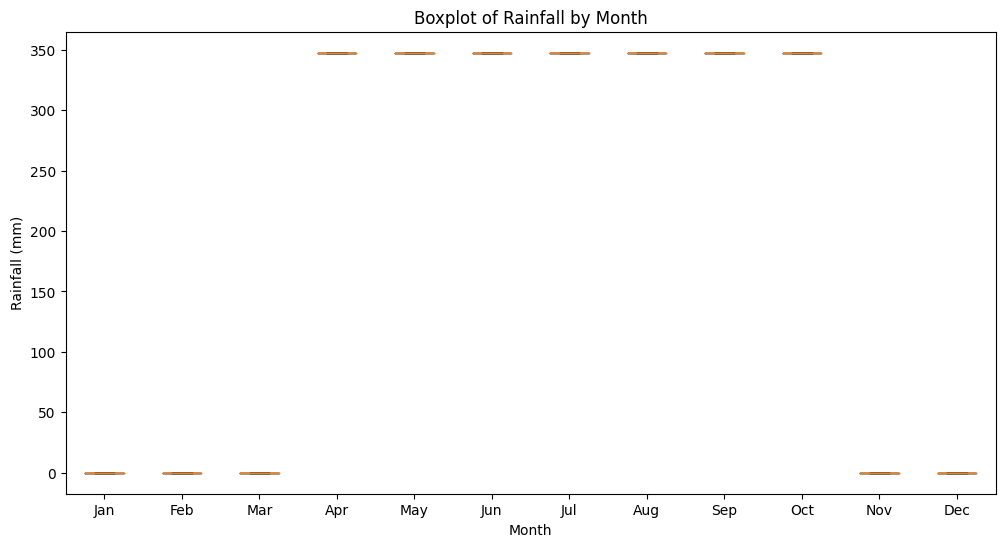

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load the dataset
df = pd.read_csv('akwaibom_malaria_dataset.csv', parse_dates=['Date'], index_col='Date')

# Rename the columns to match the existing code
df.rename(columns={'Malaria_Cases': 'Cases'}, inplace=True)

# Ensure the index is a DatetimeIndex
if not isinstance(df.index, pd.DatetimeIndex):
    df.index = pd.to_datetime(df.index, format='%d/%m/%Y')  # Specify the correct date formatimeIndex

# Visualize the data
# Group by year
df_yearly = df.resample('M').sum()  # You can also use 'mean' instead of 'sum' depending on your data

# Plotting monthly data
plt.figure(figsize=(12, 6))
plt.plot(df_yearly.index, df_yearly['Cases'], label='Malaria Cases (yearly)', color='blue')
plt.title('Yearly Malaria Cases Over Time', fontsize=14)
plt.xlabel('Years', fontsize=12)
plt.ylabel('Number of Cases', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


# Extract month from the date
df['Month'] = df.index.month # Extract month from the index since 'Date' is the index


# Plot the boxplot of rainfall against months
plt.figure(figsize=(12, 6))
plt.boxplot([df[df['Month'] == month]['Rainfall'] for month in range(1, 13)], labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.title('Boxplot of Rainfall by Month')
plt.xlabel('Month')
plt.ylabel('Rainfall (mm)')
plt.show()



### Explanation:
Introduce the dataset (malaria_data.csv) and its importance.
Visualize the time series data to understand its trends and patterns.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


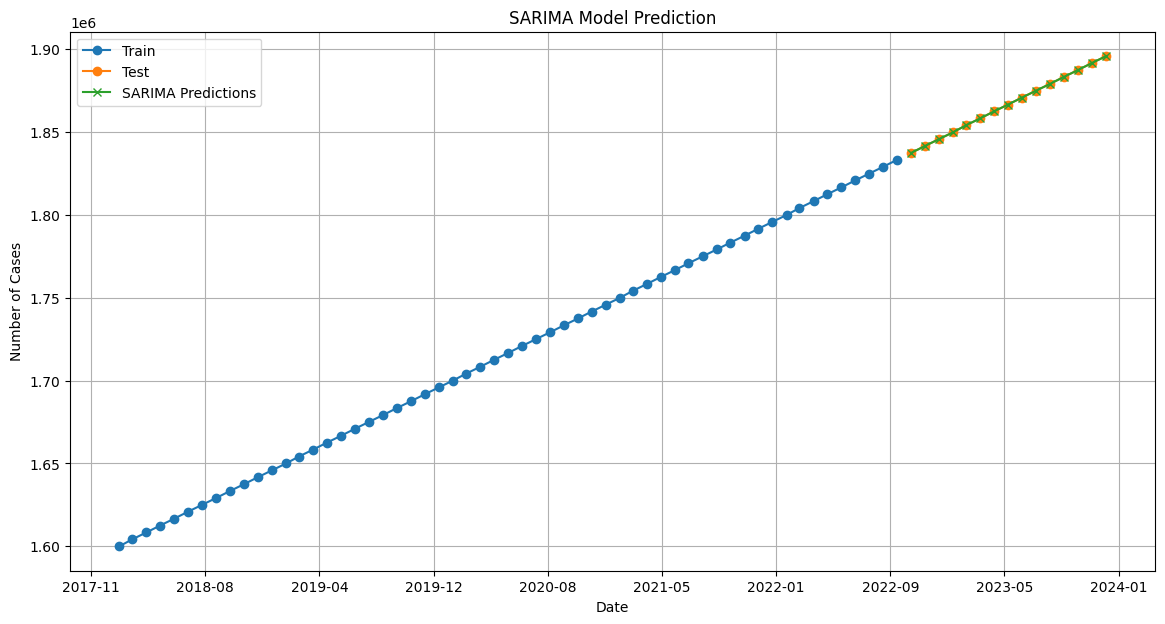

In [3]:
# Split data into train and test sets
train = df['Cases'][:int(0.8 * len(df))]
test = df['Cases'][int(0.8 * len(df)):]

# Fit SARIMA model
sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_results = sarima_model.fit()

# Predict with SARIMA
sarima_predictions = sarima_results.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)

# Ensure SARIMA predictions align with test set length
sarima_predictions = sarima_predictions[:len(test)]

# Visualize SARIMA results with clearer date formatting
plt.figure(figsize=(14, 7))
plt.plot(train, label='Train', marker='o')
plt.plot(test, label='Test', marker='o')
plt.plot(test.index, sarima_predictions, label='SARIMA Predictions', marker='x')

# Improve x-axis date formatting
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))

plt.legend()
plt.title('SARIMA Model Prediction')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.grid(True)
plt.show()

### Explanation:
*   Split the data into training and testing subsets.
*   Implement the SARIMA model (order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).
*   Make predictions with SARIMA and visualize the predictions against the actual test data.

In [4]:
# Scale data for LSTM
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Cases']])

# Create sequences for LSTM
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10
X, y = create_sequences(scaled_data, seq_length)

# Split sequences into train and test sets
X_train, X_test = X[:int(0.8 * len(X))], X[int(0.8 * len(X)):]
y_train, y_test = y[:int(0.8 * len(y))], y[int(0.8 * len(y)):]

# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=20, batch_size=32)

# Predict with LSTM
lstm_predictions = model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions)

# Ensure LSTM predictions align with test set length
lstm_predictions = lstm_predictions[:len(test)]

Epoch 1/20
2/2 [==============================] - 8s 18ms/step - loss: 0.3058
Epoch 2/20
2/2 [==============================] - 0s 14ms/step - loss: 0.2485
Epoch 3/20
2/2 [==============================] - 0s 14ms/step - loss: 0.1918
Epoch 4/20
2/2 [==============================] - 0s 13ms/step - loss: 0.1418
Epoch 5/20
2/2 [==============================] - 0s 13ms/step - loss: 0.0973
Epoch 6/20
2/2 [==============================] - 0s 15ms/step - loss: 0.0518
Epoch 7/20
2/2 [==============================] - 0s 13ms/step - loss: 0.0196
Epoch 8/20
2/2 [==============================] - 0s 13ms/step - loss: 0.0053
Epoch 9/20
2/2 [==============================] - 0s 13ms/step - loss: 0.0222
Epoch 10/20
2/2 [==============================] - 0s 13ms/step - loss: 0.0356
Epoch 11/20
2/2 [==============================] - 0s 14ms/step - loss: 0.0218
Epoch 12/20
2/2 [==============================] - 0s 13ms/step - loss: 0.0098
Epoch 13/20
2/2 [==============================] - 0s 13ms/st

### Explanation:

Scale the dataset using MinMaxScaler for LSTM training.
Create sequences of data (X and y) suitable for LSTM model training.
Split sequences into training and testing subsets.
Construct an LSTM model using Sequential API with LSTM, Dropout, and Dense layers.
Compile and train the LSTM model on the training data.
Make predictions using the trained LSTM model and inverse transform to get actual values.
Ensure predictions match the length of the test set.

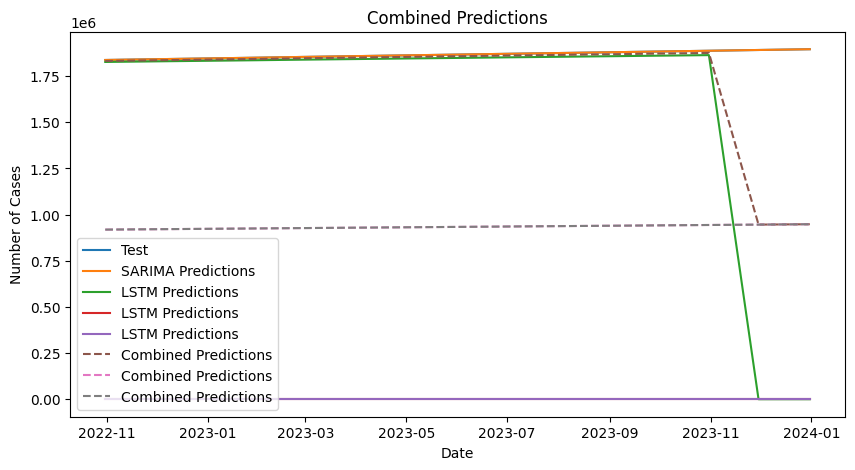

In [5]:
# Pad lstm_predictions with zeros to match the length of sarima_predictions
lstm_predictions_padded = np.pad(lstm_predictions, (0, len(test) - len(lstm_predictions)), 'constant')

# Reshape sarima_predictions to match the shape of lstm_predictions_padded
sarima_predictions_reshaped = sarima_predictions.values.reshape(-1, 1)

# Combine predictions (example of calculating mean)
combined_predictions = (sarima_predictions_reshaped + lstm_predictions_padded) / 2

# Ensure combined predictions align with test set length
combined_predictions = combined_predictions[:len(test)]

# Visualize the combined results
plt.figure(figsize=(10, 5))
plt.plot(test.index, test.values, label='Test')
plt.plot(test.index, sarima_predictions, label='SARIMA Predictions')
plt.plot(test.index, lstm_predictions_padded, label='LSTM Predictions')
plt.plot(test.index, combined_predictions, label='Combined Predictions', linestyle='--')
plt.legend()
plt.title('Combined Predictions')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.show()

### Explanation:
Combine SARIMA and LSTM predictions using a simple mean.

Ensure combined predictions match the length of the test set.

Visualize SARIMA, LSTM, and combined predictions alongside the actual test data.

In [6]:
# Calculate and print metrics
mae_sarima = mean_absolute_error(test[:len(sarima_predictions)], sarima_predictions)
rmse_sarima = np.sqrt(mean_squared_error(test[:len(sarima_predictions)], sarima_predictions))

mae_lstm = mean_absolute_error(test[:len(lstm_predictions)], lstm_predictions)
rmse_lstm = np.sqrt(mean_squared_error(test[:len(lstm_predictions)], lstm_predictions))

# Extract the first column of combined_predictions (assuming it's the relevant one)
combined_predictions_single = combined_predictions[:, 0]

mae_combined = mean_absolute_error(test.values[:len(combined_predictions_single)], combined_predictions_single)
rmse_combined = np.sqrt(mean_squared_error(test.values[:len(combined_predictions_single)], combined_predictions_single))

print(f'SARIMA MAE: {mae_sarima}, RMSE: {rmse_sarima}')
print(f'LSTM MAE: {mae_lstm}, RMSE: {rmse_lstm}')
print(f'Combined MAE: {mae_combined}, RMSE: {rmse_combined}')

SARIMA MAE: 1.0865430037180583e-10, RMSE: 1.8034984107163814e-10
LSTM MAE: 17001.35576923077, RMSE: 17481.258410692128
Combined MAE: 133617.22083333335, RMSE: 345845.7205794726


Evaluate Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) for SARIMA, LSTM, and combined predictions. Then print out the metrics to assess the performance of each model.

In [7]:
# Save SARIMA model
sarima_results.save('sarima_model.pkl')

# Save LSTM model
model.save('lstm_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [8]:
!pip install flask-cors

# Depoly the model using flask

In [ ]:
from flask import Flask, request, jsonify, render_template
from flask_cors import CORS
import pandas as pd
import numpy as np
import joblib
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

app = Flask(__name__)
CORS(app)  # Enable CORS for all routes

# Load the models
sarima_model = joblib.load('sarima_model.pkl')
lstm_model = load_model('lstm_model.h5')

# Function to preprocess input data
def preprocess_data(data):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaler

# Function to create sequences for LSTM
def create_sequences(data, seq_length):
    xs = []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        xs.append(x)
    return np.array(xs)

# Route for home page
@app.route('/')
def home():
    return render_template('index.html')

# Route for making predictions
@app.route('/predict', methods=['POST'])
def predict():
    try:
        # Get the data from the request
        data = request.get_json()
        df = pd.DataFrame(data)

        # Preprocess the data
        scaled_data, scaler = preprocess_data(df[['Cases']])

        # Create sequences for LSTM
        seq_length = 10
        X = create_sequences(scaled_data, seq_length)

        # Predict with LSTM
        lstm_predictions = lstm_model.predict(X)
        lstm_predictions = scaler.inverse_transform(lstm_predictions)

        # Pad lstm_predictions with zeros to match the length of sarima_predictions
        lstm_predictions_padded = np.pad(lstm_predictions, (0, len(df) - len(lstm_predictions)), 'constant')

        # Predict with SARIMA
        sarima_predictions = sarima_model.get_forecast(steps=len(df)).predicted_mean
        sarima_predictions = sarima_predictions.values.reshape(-1, 1)

        # Combine predictions (example of calculating mean)
        combined_predictions = (sarima_predictions + lstm_predictions_padded) / 2

        # Return the predictions as a JSON response
        predictions = combined_predictions.flatten().tolist()
        return jsonify(predictions=predictions)

    except Exception as e:
        return jsonify(error=str(e))

app.run(debug=True)

 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat
